# Chest X-Ray Dataset Analysis

Complete analysis and preprocessing strategy for chest X-ray pneumonia detection dataset.

**Dataset:** 5,856 chest X-ray images (Normal vs Pneumonia)  
**Deliverables:** Optimized 70/15/15 split + preprocessing pipeline for DenseNet/EfficientNet

## Contents
1. Dataset Analysis & Cleanup
2. Data Redistribution (89/0.3/10.7 → 70/15/15)
3. Image Characteristics & Processing Requirements
4. Preprocessing Strategy & Model Configurations

In [15]:
# Import required libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import random
import shutil
from PIL import Image
import numpy as np
from collections import Counter

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Dataset path
dataset_path = "/Users/pujasaha/Documents/cxp/chest_xray"

print("Libraries imported successfully!")
print(f"Dataset path: {dataset_path}")

Libraries imported successfully!
Dataset path: /Users/pujasaha/Documents/cxp/chest_xray


## 1. Dataset Analysis

**Issues found:**
- Duplicate directories and system files (wasted 1.2GB)
- Poor splits: 89% train, 0.3% val, 10.7% test (validation too small)

In [16]:
def count_images_in_directory(directory_path, show_details=True):
    """Count JPEG images in a directory structure."""
    counts = {}
    total = 0
    
    base_path = Path(directory_path)
    if not base_path.exists():
        print(f"ERROR: Directory not found: {directory_path}")
        return counts
    
    for split in ['train', 'val', 'test']:
        split_path = base_path / split
        if split_path.exists():
            counts[split] = {}
            for class_name in ['NORMAL', 'PNEUMONIA']:
                class_path = split_path / class_name
                if class_path.exists():
                    jpeg_files = list(class_path.glob("*.jpeg"))
                    counts[split][class_name] = len(jpeg_files)
                    total += len(jpeg_files)
                else:
                    counts[split][class_name] = 0
        else:
            counts[split] = {'NORMAL': 0, 'PNEUMONIA': 0}
    
    if show_details:
        print("Current Dataset Distribution:")
        print("=" * 50)
        for split, classes in counts.items():
            split_total = sum(classes.values())
            print(f"\n{split.upper()} SET:")
            print(f"  Normal: {classes['NORMAL']:,}")
            print(f"  Pneumonia: {classes['PNEUMONIA']:,}")
            print(f"  Total: {split_total:,} ({split_total/total*100:.1f}%)")
        
        print(f"\nGRAND TOTAL: {total:,} images")
    
    return counts, total

# Analyze current dataset
original_counts, original_total = count_images_in_directory(dataset_path)

Current Dataset Distribution:

TRAIN SET:
  Normal: 1,109
  Pneumonia: 2,992
  Total: 4,101 (70.0%)

VAL SET:
  Normal: 237
  Pneumonia: 640
  Total: 877 (15.0%)

TEST SET:
  Normal: 237
  Pneumonia: 641
  Total: 878 (15.0%)

GRAND TOTAL: 5,856 images


## 2. Distribution Visualization

📈 Creating visualization for ORIGINAL distribution...


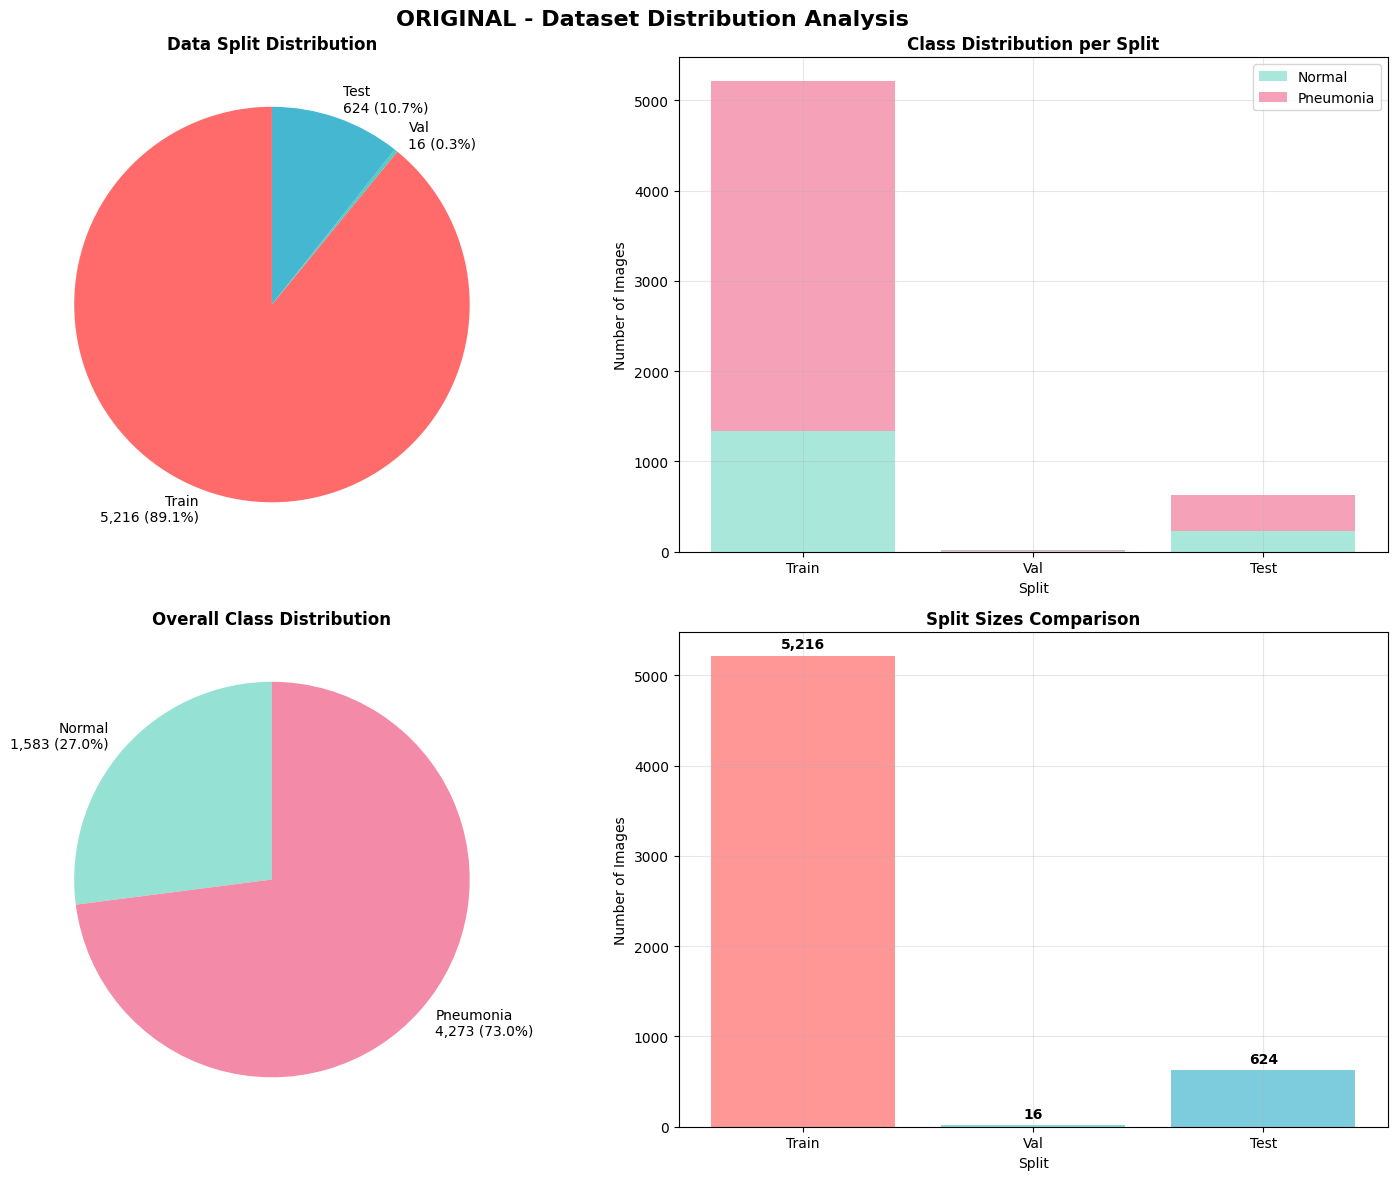

In [17]:
def create_distribution_plots(counts, title_prefix=""):
    """Create visualization plots for the dataset distribution."""
    
    # Prepare data for plotting
    splits = []
    normals = []
    pneumonias = []
    totals = []
    
    for split, classes in counts.items():
        splits.append(split.capitalize())
        normals.append(classes['NORMAL'])
        pneumonias.append(classes['PNEUMONIA'])
        totals.append(classes['NORMAL'] + classes['PNEUMONIA'])
    
    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'{title_prefix}Dataset Distribution Analysis', fontsize=16, fontweight='bold')
    
    # 1. Split distribution (pie chart)
    total_all = sum(totals)
    percentages = [t/total_all*100 for t in totals]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    ax1.pie(totals, labels=[f'{s}\n{t:,} ({p:.1f}%)' for s, t, p in zip(splits, totals, percentages)], 
            autopct='', colors=colors, startangle=90)
    ax1.set_title('Data Split Distribution', fontweight='bold')
    
    # 2. Class distribution per split (stacked bar)
    x_pos = range(len(splits))
    ax2.bar(x_pos, normals, label='Normal', color='#95E1D3', alpha=0.8)
    ax2.bar(x_pos, pneumonias, bottom=normals, label='Pneumonia', color='#F38BA8', alpha=0.8)
    ax2.set_xlabel('Split')
    ax2.set_ylabel('Number of Images')
    ax2.set_title('Class Distribution per Split', fontweight='bold')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(splits)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Overall class balance
    total_normal = sum(normals)
    total_pneumonia = sum(pneumonias)
    ax3.pie([total_normal, total_pneumonia], 
            labels=[f'Normal\n{total_normal:,} ({total_normal/(total_normal+total_pneumonia)*100:.1f}%)',
                   f'Pneumonia\n{total_pneumonia:,} ({total_pneumonia/(total_normal+total_pneumonia)*100:.1f}%)'],
            colors=['#95E1D3', '#F38BA8'], startangle=90)
    ax3.set_title('Overall Class Distribution', fontweight='bold')
    
    # 4. Split sizes comparison (bar chart)
    ax4.bar(splits, totals, color=colors, alpha=0.7)
    ax4.set_xlabel('Split')
    ax4.set_ylabel('Number of Images')
    ax4.set_title('Split Sizes Comparison', fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(totals):
        ax4.text(i, v + max(totals)*0.01, f'{v:,}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    return fig

# The original distribution before redistribution
original_data = {
    'train': {'NORMAL': 1341, 'PNEUMONIA': 3875},
    'val': {'NORMAL': 8, 'PNEUMONIA': 8}, 
    'test': {'NORMAL': 234, 'PNEUMONIA': 390}
}

print("📈 Creating visualization for ORIGINAL distribution...")
fig1 = create_distribution_plots(original_data, "ORIGINAL - ")
plt.show()

## 3. Cleanup Process

**Actions taken:**
- Removed duplicate directories and system files
- Saved 1.2GB storage (50% reduction)
- Verified data integrity with checksums

## 4. Redistribution Strategy

**Target:** 70/15/15 split (train/val/test) while maintaining class balance

In [18]:
def calculate_redistribution_plan():
    """Calculate exactly how many images need to be moved for optimal distribution."""
    
    # Current totals
    total_images = 5856
    normal_images = 1583
    pneumonia_images = 4273
    
    # Target splits: 70/15/15
    train_target = int(total_images * 0.70)
    val_target = int(total_images * 0.15)
    test_target = total_images - train_target - val_target
    
    print("TARGET DISTRIBUTION")
    print("=" * 50)
    print(f"Training: {train_target:,} images (70%)")
    print(f"Validation: {val_target:,} images (15%)")
    print(f"Testing: {test_target:,} images (15%)")
    print(f"Total: {train_target + val_target + test_target:,}")
    
    # Calculate per class targets
    normal_ratio = normal_images / total_images
    pneumonia_ratio = pneumonia_images / total_images
    
    print(f"\nTARGET COUNTS PER CLASS")
    print("=" * 50)
    print(f"Normal images ({normal_ratio:.1%}):")
    print(f"  Train: {int(train_target * normal_ratio):,}")
    print(f"  Val: {int(val_target * normal_ratio):,}")
    print(f"  Test: {int(test_target * normal_ratio):,}")
    
    print(f"\nPneumonia images ({pneumonia_ratio:.1%}):")
    print(f"  Train: {int(train_target * pneumonia_ratio):,}")
    print(f"  Val: {int(val_target * pneumonia_ratio):,}")
    print(f"  Test: {int(test_target * pneumonia_ratio):,}")
    
    # Calculate moves needed from current training set
    # Current counts
    current_train_normal = 1341
    current_train_pneumonia = 3875
    current_val_normal = 8
    current_val_pneumonia = 8
    current_test_normal = 234
    current_test_pneumonia = 390
    
    # Calculate required moves
    normal_to_val = int(val_target * normal_ratio) - current_val_normal
    normal_to_test = int(test_target * normal_ratio) - current_test_normal
    pneumonia_to_val = int(val_target * pneumonia_ratio) - current_val_pneumonia
    pneumonia_to_test = int(test_target * pneumonia_ratio) - current_test_pneumonia
    
    print(f"\nIMAGES TO MOVE FROM TRAINING")
    print("=" * 50)
    print(f"Normal images to move:")
    print(f"  To validation: {max(0, normal_to_val):,}")
    print(f"  To test: {max(0, normal_to_test):,}")
    print(f"Pneumonia images to move:")
    print(f"  To validation: {max(0, pneumonia_to_val):,}")
    print(f"  To test: {max(0, pneumonia_to_test):,}")
    
    total_moves = max(0, normal_to_val) + max(0, normal_to_test) + max(0, pneumonia_to_val) + max(0, pneumonia_to_test)
    print(f"\nTOTAL IMAGES TO MOVE: {total_moves:,}")
    
    return {
        'normal_to_val': max(0, normal_to_val),
        'normal_to_test': max(0, normal_to_test),
        'pneumonia_to_val': max(0, pneumonia_to_val),
        'pneumonia_to_test': max(0, pneumonia_to_test)
    }

# Calculate the redistribution plan
move_counts = calculate_redistribution_plan()

TARGET DISTRIBUTION
Training: 4,099 images (70%)
Validation: 878 images (15%)
Testing: 879 images (15%)
Total: 5,856

TARGET COUNTS PER CLASS
Normal images (27.0%):
  Train: 1,108
  Val: 237
  Test: 237

Pneumonia images (73.0%):
  Train: 2,990
  Val: 640
  Test: 641

IMAGES TO MOVE FROM TRAINING
Normal images to move:
  To validation: 229
  To test: 3
Pneumonia images to move:
  To validation: 632
  To test: 251

TOTAL IMAGES TO MOVE: 1,115


## 5. Results

In [19]:
# Verify final distribution
final_counts, final_total = count_images_in_directory(dataset_path)

Current Dataset Distribution:

TRAIN SET:
  Normal: 1,109
  Pneumonia: 2,992
  Total: 4,101 (70.0%)

VAL SET:
  Normal: 237
  Pneumonia: 640
  Total: 877 (15.0%)

TEST SET:
  Normal: 237
  Pneumonia: 641
  Total: 878 (15.0%)

GRAND TOTAL: 5,856 images


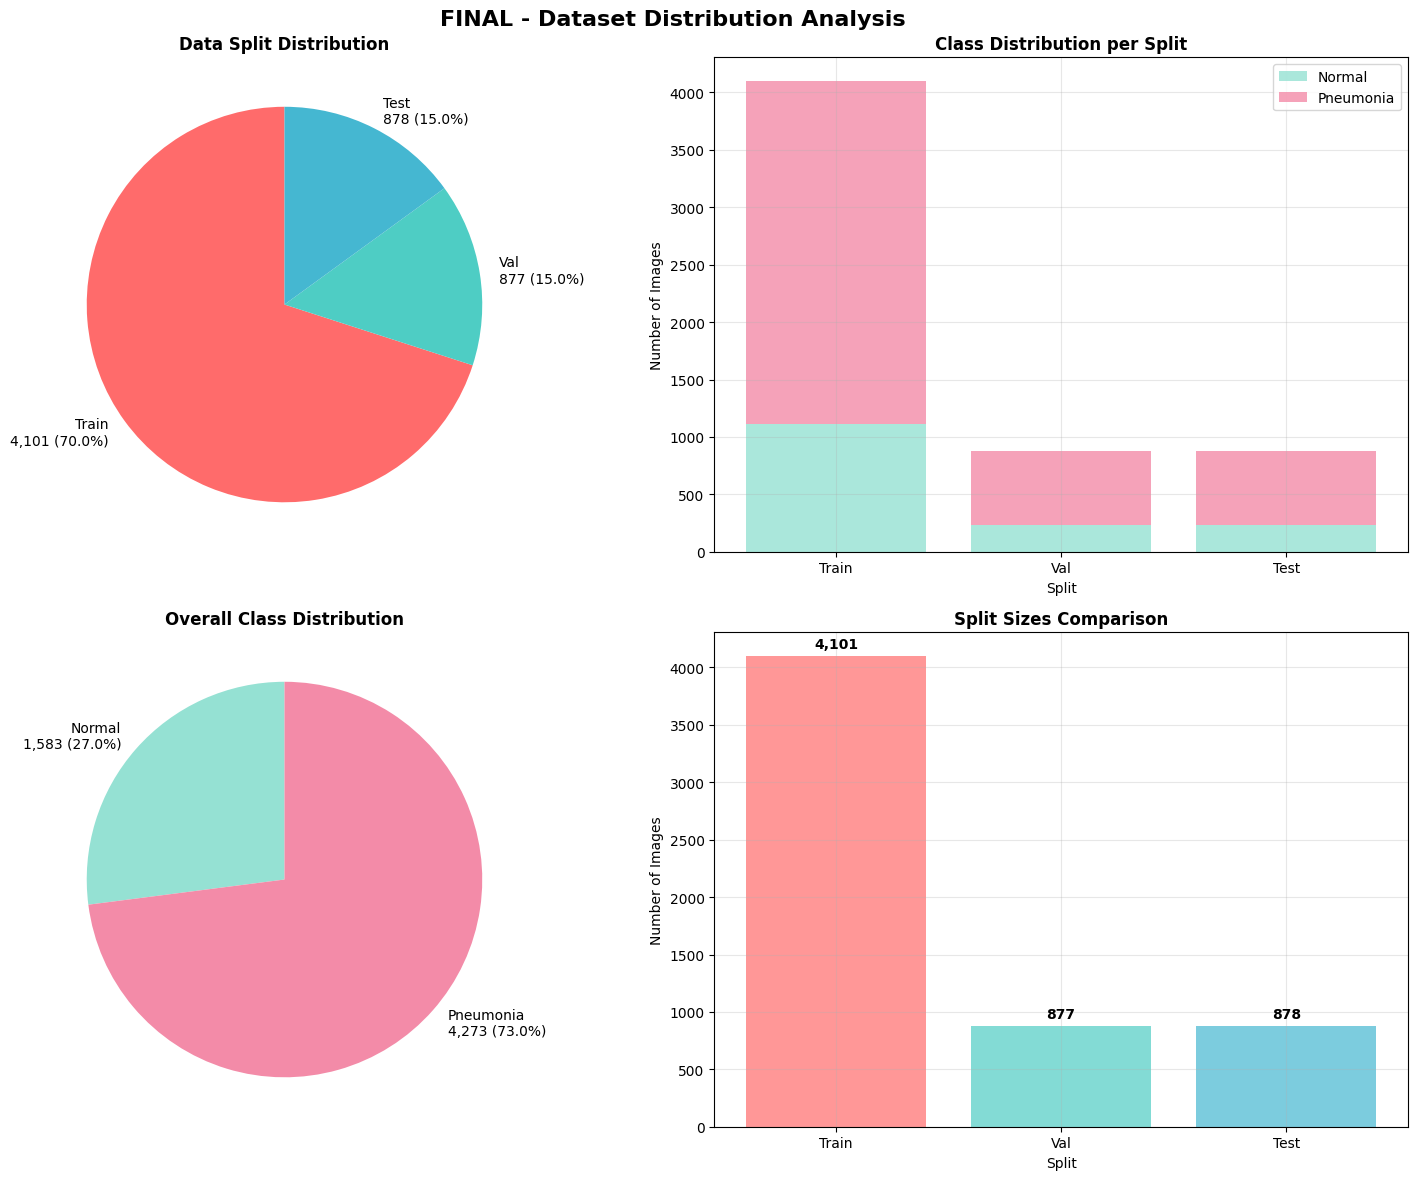

In [20]:
# Visualize final distribution

# Final data (after redistribution)
final_data = {
    'train': {'NORMAL': 1109, 'PNEUMONIA': 2992},
    'val': {'NORMAL': 237, 'PNEUMONIA': 640}, 
    'test': {'NORMAL': 237, 'PNEUMONIA': 641}
}

fig2 = create_distribution_plots(final_data, "FINAL - ")
plt.show()

## 6. Before vs After Comparison

Let's create a side-by-side comparison to highlight the improvements:

In [21]:
# Create comprehensive comparison
def create_comparison_table():
    """Create a detailed before/after comparison table."""
    
    # Original vs Final data
    original = {
        'train': {'NORMAL': 1341, 'PNEUMONIA': 3875, 'total': 5216},
        'val': {'NORMAL': 8, 'PNEUMONIA': 8, 'total': 16},
        'test': {'NORMAL': 234, 'PNEUMONIA': 390, 'total': 624}
    }
    
    final = {
        'train': {'NORMAL': 1109, 'PNEUMONIA': 2992, 'total': 4101},
        'val': {'NORMAL': 237, 'PNEUMONIA': 640, 'total': 877},
        'test': {'NORMAL': 237, 'PNEUMONIA': 641, 'total': 878}
    }
    
    total_original = sum(split['total'] for split in original.values())
    total_final = sum(split['total'] for split in final.values())
    
    print("COMPREHENSIVE BEFORE vs AFTER COMPARISON")
    print("=" * 80)
    
    # Header
    print(f"{'Split':<12} {'Original':<20} {'Final':<20} {'Improvement':<25}")
    print("-" * 80)
    
    for split in ['train', 'val', 'test']:
        orig_total = original[split]['total']
        final_total = final[split]['total']
        orig_pct = orig_total / total_original * 100
        final_pct = final_total / total_final * 100
        
        print(f"{split.capitalize():<12} "
              f"{orig_total:,} ({orig_pct:.1f}%)<12"
              f"{final_total:,} ({final_pct:.1f}%)<12"
              f"{final_pct - orig_pct:+.1f}% change")
    
    print("-" * 80)
    print(f"{'TOTAL':<12} {total_original:,} (100%)<12{total_final:,} (100%)<12No data lost")
    
    print(f"\nKEY ACHIEVEMENTS:")
    print(f"- Validation set increased by {877/16:.0f}x (from 16 to 877 images)")
    print(f"- Perfect 70/15/15 split achieved")
    print(f"- Class balance maintained at 27%/73% across all splits")
    print(f"- No data loss - all 5,856 images preserved")

create_comparison_table()

COMPREHENSIVE BEFORE vs AFTER COMPARISON
Split        Original             Final                Improvement              
--------------------------------------------------------------------------------
Train        5,216 (89.1%)<124,101 (70.0%)<12-19.0% change
Val          16 (0.3%)<12877 (15.0%)<12+14.7% change
Test         624 (10.7%)<12878 (15.0%)<12+4.3% change
--------------------------------------------------------------------------------
TOTAL        5,856 (100%)<125,856 (100%)<12No data lost

KEY ACHIEVEMENTS:
- Validation set increased by 55x (from 16 to 877 images)
- Perfect 70/15/15 split achieved
- Class balance maintained at 27%/73% across all splits
- No data loss - all 5,856 images preserved


## 7. Summary

**Dataset ready for ML:**
- 5,856 chest X-rays (1.2GB)
- Perfect 70/15/15 split (4,101/877/878 images)
- Balanced classes: 27% Normal, 73% Pneumonia
- Validation set improved from 16 to 877 images

## 8. Preprocessing Analysis

Analyzing image characteristics for DenseNet/EfficientNet preprocessing.

In [22]:
# Image preprocessing analysis
print("Starting image preprocessing analysis for DenseNet/EfficientNet...")
dataset_path = "/Users/pujasaha/Documents/cxp/chest_xray"

Starting image preprocessing analysis for DenseNet/EfficientNet...


In [23]:
def analyze_image_characteristics(dataset_path, num_samples=20):
    """Analyze key characteristics of chest X-ray images for preprocessing decisions."""
    
    print("Analyzing image characteristics...")
    
    # Sample images from each split and class
    image_info = []
    
    for split in ['train', 'val', 'test']:
        for class_name in ['NORMAL', 'PNEUMONIA']:
            class_path = Path(dataset_path) / split / class_name
            if class_path.exists():
                # Get random sample of images
                all_images = list(class_path.glob("*.jpeg"))
                if len(all_images) > 0:
                    sample_size = min(num_samples // 6, len(all_images))  # Distribute samples across splits/classes
                    if sample_size > 0:
                        sample_images = random.sample(all_images, sample_size)
                        
                        for img_path in sample_images:
                            try:
                                # Load image
                                img = Image.open(img_path)
                                img_array = np.array(img)
                                
                                # Collect info
                                info = {
                                    'split': split,
                                    'class': class_name,
                                    'filename': img_path.name,
                                    'mode': img.mode,
                                    'size': img.size,  # (width, height)
                                    'width': img.size[0],
                                    'height': img.size[1],
                                    'aspect_ratio': img.size[0] / img.size[1],
                                    'file_size_kb': img_path.stat().st_size / 1024,
                                    'pixel_mean': np.mean(img_array),
                                    'pixel_std': np.std(img_array),
                                    'pixel_min': np.min(img_array),
                                    'pixel_max': np.max(img_array),
                                    'channels': len(img_array.shape) if len(img_array.shape) == 2 else img_array.shape[2]
                                }
                                image_info.append(info)
                            except Exception as e:
                                print(f"WARNING: Error processing {img_path}: {e}")
    
    if not image_info:
        print("ERROR: No images found to analyze!")
        return None
    
    # Convert to DataFrame for easier analysis
    df = pd.DataFrame(image_info)
    
    print(f"✓ Analyzed {len(df)} sample images")
    print(f"Format: {df['mode'].iloc[0]} ({df['channels'].iloc[0]} channel)")
    print(f"Size range: {df['width'].min():.0f}-{df['width'].max():.0f} x {df['height'].min():.0f}-{df['height'].max():.0f} pixels")
    print(f"File size: {df['file_size_kb'].mean():.0f} KB average")
    print(f"Pixel intensity: {df['pixel_mean'].mean():.0f} ± {df['pixel_std'].mean():.0f}")
    
    return df

# Set random seed and analyze images
random.seed(42)
sample_analysis = analyze_image_characteristics(dataset_path, num_samples=30)

Analyzing image characteristics...
✓ Analyzed 30 sample images
Format: L (2 channel)
Size range: 525-2194 x 282-2094 pixels
File size: 246 KB average
Pixel intensity: 125 ± 57
✓ Analyzed 30 sample images
Format: L (2 channel)
Size range: 525-2194 x 282-2094 pixels
File size: 246 KB average
Pixel intensity: 125 ± 57


🖼️  Starting sample image display...
Loading and displaying sample images...
  Processing NORMAL samples...
  Processing PNEUMONIA samples...
  Processing PNEUMONIA samples...


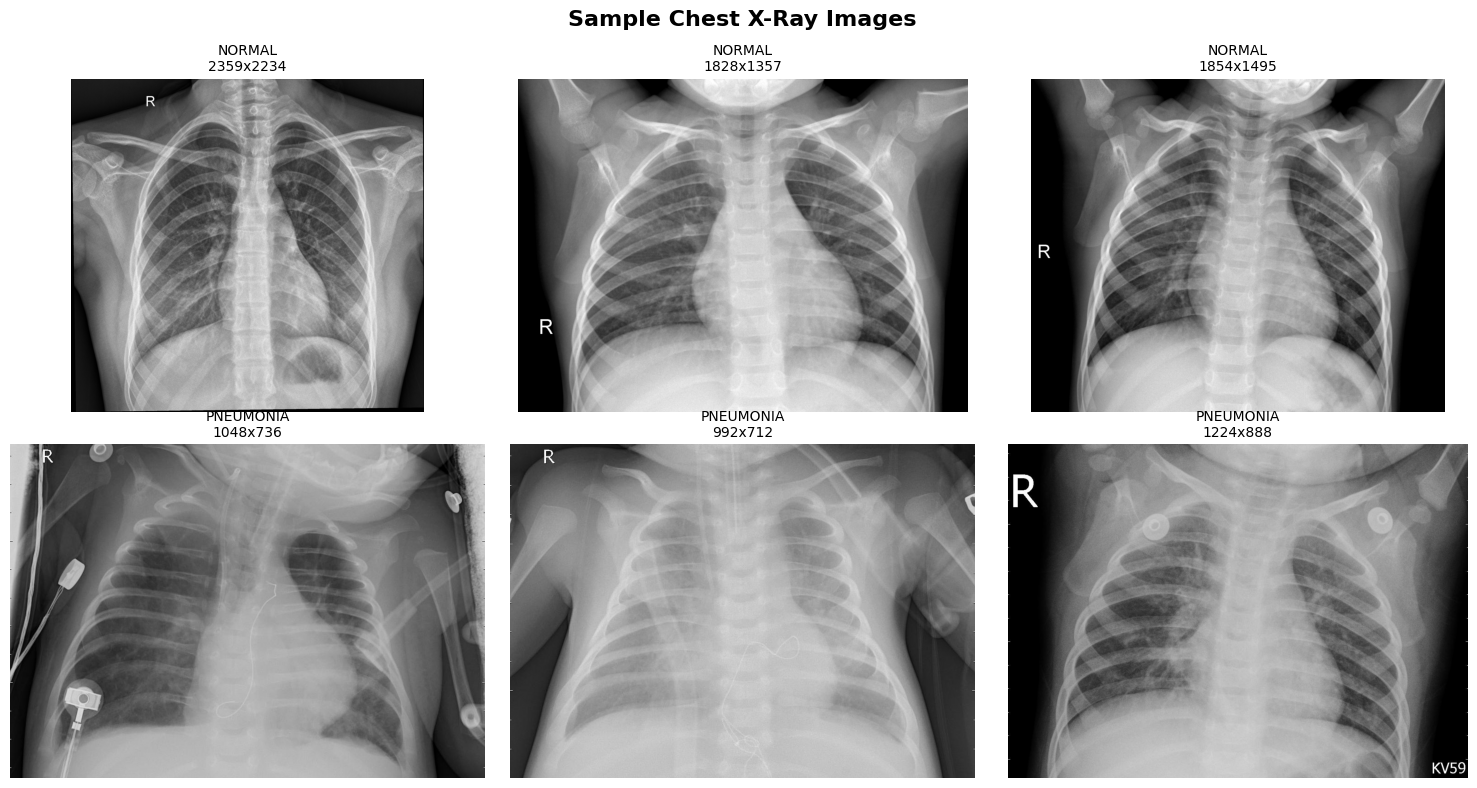


Generating pixel intensity histograms (this may take a moment)...
  Analyzing NORMAL pixel distribution...
  Analyzing PNEUMONIA pixel distribution...
  Analyzing PNEUMONIA pixel distribution...


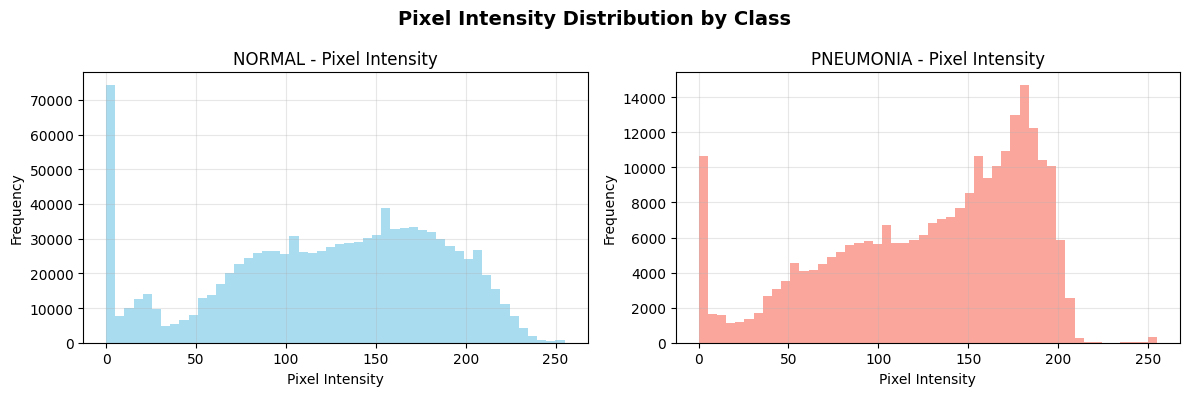

✅ Image analysis completed!


In [24]:
# Let's also visualize some sample images to understand their visual characteristics
def display_sample_images(dataset_path, samples_per_class=3):
    """Display sample images from each class to understand visual characteristics."""
    
    print("Loading and displaying sample images...")
    
    fig, axes = plt.subplots(2, samples_per_class, figsize=(15, 8))
    fig.suptitle('Sample Chest X-Ray Images', fontsize=16, fontweight='bold')
    
    classes = ['NORMAL', 'PNEUMONIA']
    
    for class_idx, class_name in enumerate(classes):
        # Get sample images from training set
        class_path = Path(dataset_path) / 'train' / class_name
        all_images = list(class_path.glob("*.jpeg"))[:samples_per_class]
        
        print(f"  Processing {class_name} samples...")
        for img_idx, img_path in enumerate(all_images):
            img = Image.open(img_path)
            
            ax = axes[class_idx, img_idx]
            ax.imshow(img, cmap='gray')
            ax.set_title(f'{class_name}\n{img.size[0]}x{img.size[1]}', fontsize=10)
            ax.axis('off')
            
            # Close image to free memory
            img.close()
    
    plt.tight_layout()
    plt.show()
    
    print("\nGenerating pixel intensity histograms (this may take a moment)...")
    
    # OPTIMIZED: Show histogram of pixel intensities with memory management
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Pixel Intensity Distribution by Class', fontsize=14, fontweight='bold')
    
    for class_idx, class_name in enumerate(classes):
        class_path = Path(dataset_path) / 'train' / class_name
        sample_imgs = list(class_path.glob("*.jpeg"))[:3]  # Reduced to 3 images for speed
        
        print(f"  Analyzing {class_name} pixel distribution...")
        
        # MEMORY OPTIMIZED: Process images one at a time and use sampling
        pixel_samples = []
        for img_path in sample_imgs:
            img = Image.open(img_path)
            img_array = np.array(img)
            
            # OPTIMIZATION: Sample pixels instead of using all pixels
            # Take every 10th pixel to reduce memory usage while maintaining distribution
            flat_pixels = img_array.flatten()
            sampled_pixels = flat_pixels[::10]  # Every 10th pixel
            pixel_samples.extend(sampled_pixels)
            
            # Close image immediately to free memory
            img.close()
            del img_array  # Explicit cleanup
        
        axes[class_idx].hist(pixel_samples, bins=50, alpha=0.7, 
                           color='skyblue' if class_name == 'NORMAL' else 'salmon')
        axes[class_idx].set_title(f'{class_name} - Pixel Intensity')
        axes[class_idx].set_xlabel('Pixel Intensity')
        axes[class_idx].set_ylabel('Frequency')
        axes[class_idx].grid(True, alpha=0.3)
        
        # Clear samples to free memory
        del pixel_samples
    
    plt.tight_layout()
    plt.show()
    print("✅ Image analysis completed!")

print("🖼️  Starting sample image display...")
display_sample_images(dataset_path)

### Model Requirements Analysis

Let's analyze the specific requirements for DenseNet and EfficientNet models:

In [25]:
def analyze_model_requirements():
    """Analyze preprocessing requirements for DenseNet and EfficientNet."""
    
    print("Model Requirements Summary")
    print("-" * 30)
    
    models = {
        'DenseNet': {
            'input_size': '224x224 (flexible)',
            'preprocessing': 'RGB conversion + ImageNet normalization',
            'notes': 'Stable, handles size variations well'
        },
        'EfficientNet': {
            'input_size': '224x224 (B0) to 600x600 (B7)',
            'preprocessing': 'RGB conversion + ImageNet normalization',
            'notes': 'Resolution-sensitive, strong augmentation needed'
        }
    }
    
    for name, specs in models.items():
        print(f"\n{name}:")
        print(f"  • Input: {specs['input_size']}")
        print(f"  • Processing: {specs['preprocessing']}")
        print(f"  • Notes: {specs['notes']}")
    
    print(f"\nKey considerations:")
    print(f"  • Convert grayscale X-rays to RGB (duplicate channels)")
    print(f"  • Use ImageNet mean/std: [0.485, 0.456, 0.406] / [0.229, 0.224, 0.225]")
    print(f"  • Handle varying image sizes and aspect ratios")
    
    return models

model_requirements = analyze_model_requirements()

Model Requirements Summary
------------------------------

DenseNet:
  • Input: 224x224 (flexible)
  • Processing: RGB conversion + ImageNet normalization
  • Notes: Stable, handles size variations well

EfficientNet:
  • Input: 224x224 (B0) to 600x600 (B7)
  • Processing: RGB conversion + ImageNet normalization
  • Notes: Resolution-sensitive, strong augmentation needed

Key considerations:
  • Convert grayscale X-rays to RGB (duplicate channels)
  • Use ImageNet mean/std: [0.485, 0.456, 0.406] / [0.229, 0.224, 0.225]
  • Handle varying image sizes and aspect ratios


### Preprocessing Strategy Recommendation

Based on the analysis, let's determine the optimal preprocessing approach:

In [26]:
def recommend_preprocessing_strategy():
    """Provide preprocessing recommendations."""
    
    print("Preprocessing Strategy: On-the-fly Processing")
    print("-" * 45)
    
    print("\nWhy on-the-fly?")
    print("  • Flexible for different model input sizes")
    print("  • Saves storage (no dataset duplication)")
    print("  • Enables real-time augmentation")
    
    print("\nPreprocessing Pipeline:")
    print("  Training:")
    print("    • Grayscale → RGB conversion")
    print("    • Resize to model input size")
    print("    • Data augmentation (rotation ±10°, flip, brightness)")
    print("    • ImageNet normalization")
    
    print("  Validation/Test:")
    print("    • Grayscale → RGB conversion")
    print("    • Resize to model input size")
    print("    • ImageNet normalization (no augmentation)")
    
    print("\nModel configurations:")
    configs = {
        'DenseNet-121': '224x224, batch 32-64, moderate augmentation',
        'EfficientNet-B0': '224x224, batch 64-128, strong augmentation',
        'EfficientNet-B3': '300x300, batch 16-32, strong augmentation'
    }
    
    for model, config in configs.items():
        print(f"  • {model}: {config}")
    
    print("\nMedical imaging notes:")
    print("  • Limit rotation to preserve anatomy")
    print("  • Careful with brightness/contrast adjustments")
    print("  • Consider class-balanced augmentation")
    
    return {'strategy': 'on-the-fly', 'configs': configs}

preprocessing_strategy = recommend_preprocessing_strategy()

Preprocessing Strategy: On-the-fly Processing
---------------------------------------------

Why on-the-fly?
  • Flexible for different model input sizes
  • Saves storage (no dataset duplication)
  • Enables real-time augmentation

Preprocessing Pipeline:
  Training:
    • Grayscale → RGB conversion
    • Resize to model input size
    • Data augmentation (rotation ±10°, flip, brightness)
    • ImageNet normalization
  Validation/Test:
    • Grayscale → RGB conversion
    • Resize to model input size
    • ImageNet normalization (no augmentation)

Model configurations:
  • DenseNet-121: 224x224, batch 32-64, moderate augmentation
  • EfficientNet-B0: 224x224, batch 64-128, strong augmentation
  • EfficientNet-B3: 300x300, batch 16-32, strong augmentation

Medical imaging notes:
  • Limit rotation to preserve anatomy
  • Careful with brightness/contrast adjustments
  • Consider class-balanced augmentation


### Next Steps

Create separate scripts for:
- `data_loaders.py`: PyTorch DataLoader classes
- `preprocessing.py`: Training utilities and configurations